Target is calculated as:
$$ Target_t = (\frac{StockWAP_{t+60}}{StockWAP_t}-\frac{IndexWAP_{t+60}}{IndexWAP_t}) * 10000$$
which is also equal to: $$ Target_t = (\frac{StockWAP_{t+60}}{StockWAP_t}-1-(\frac{IndexWAP_{t+60}}{IndexWAP_t}-1)) * 10000 $$
We don't know the value of $IndexWAP$, we can solve for it as:
$$ \frac{IndexWAP_{t+60}}{IndexWAP_t} - 1= \frac{StockWAP_{t+60}}{StockWAP_t} - 1 - \frac{Target_t}{10000} $$

In [40]:
import importlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm
from sklearn.metrics import mean_absolute_error
from statistics import mean
import utilities as u

importlib.reload(u)

plt.rcParams['figure.figsize'] = [8, 5]

In [26]:
df = pd.read_csv('train.csv')
# df = df.set_index(['stock_id', 'date_id'])
df = df.set_index(['row_id'])

Since the index is composed of the stocks, we can use the following linear equation to derive the index:

$$ \sum_{s \in S} \alpha_s * (\frac{StockWAP_{t+60, s}}{StockWAP_{t, s}} - 1)  = \frac{IndexWAP_{t+60}}{IndexWAP_t} - 1 $$

Where $S$ is a set of all stocks, $\forall{}s\in{}S, \alpha_s \in R$, $ StockWAP_{t, s}$ is WAP of stock $s$ at time $t$
We can use linear regression to estimate $\alpha_s$

In [82]:
# https://www.kaggle.com/competitions/optiver-trading-at-the-close/discussion/442851
def train_weights(df_train):
    num_stocks = df["stock_id"].nunique()
    num_dates = df["date_id"].nunique()
    num_updates = df["seconds_in_bucket"].nunique()

    print(f"# stocks         : {num_stocks}")
    print(f"# dates          : {num_dates}")
    print(f"# updates per day: {num_updates}")

    stock_returns = np.zeros((num_stocks, num_dates, num_updates))
    index_returns = np.zeros((num_stocks, num_dates, num_updates))

    for (stock_id, date_id), frame in tqdm(df.groupby(["stock_id", "date_id"])):
        frame["stock_return"] = ((frame["wap"].shift(-6) / frame["wap"]) - 1) * 10_000
        frame["index_return"] = frame["stock_return"] - frame["target"]

        stock_returns[stock_id, date_id] = frame["stock_return"].values
        index_returns[stock_id, date_id] = frame["index_return"].values

    index_return = np.mean(index_returns, axis=0)

    lr = LinearRegression()
    y = index_return.reshape(-1)
    X = stock_returns.reshape((num_stocks, -1)).T

    mask = ~(np.isnan(y) | np.isnan(X).any(axis=1))
    X, y = X[mask], y[mask]
    lr.fit(X, y)

    print(" Fit ".center(80, ">"))
    print("Coef:", lr.coef_)
    print("Intercept:", lr.intercept_)
    print("R2:", r2_score(y, lr.predict(X)))

    lr.coef_ = lr.coef_.round(3)
    lr.intercept_ = 0.0
    print(" Round with 3 digits ".center(80, ">"))
    print("Coef:", lr.coef_)
    print("Sum of Coef:", lr.coef_.sum())
    print("R2:", r2_score(y, lr.predict(X)))
    print("MAE:", mean_absolute_error(y, lr.predict(X)))
    return lr

# Verify target calculation

In [83]:
def mae(df_test, lr):
    ip = u.IndexPredictor(lr.coef_)
    MAEs = []
    for date_id, frame in tqdm(df_test.groupby("date_id")):
        for i in range(0, 550 - 60, 10):

            pred = ip.predict_target_df(df_now=frame[frame['seconds_in_bucket'] == i],
                                        df_future=frame[frame['seconds_in_bucket'] == i + 60])

            target = u.extract_array(frame[frame['seconds_in_bucket'] == i], key='target', default=np.nan)
            mask = (~np.isnan(target)) & (~np.isnan(pred))
            if sum(mask) > 0:
                MAEs.append(mean_absolute_error(target[mask], pred[mask]))
    print(f"Test variance: {np.var(df_test['target'])}")
    print(f"Test min: {np.min(df_test['target'])}")
    print(f"Test max: {np.max(df_test['target'])}")
    print(f"Test mean: {np.mean(df_test['target'])}")

    print(f"Mean absolute error is: {mean(MAEs)}")

In [84]:
date_id_cutoff = 300
df_train = df[df['date_id'] < date_id_cutoff]
df_test = df[df['date_id'] >= date_id_cutoff]

lr_train = train_weights(df_train)
mae(df_test, lr_train)

# stocks         : 200
# dates          : 481
# updates per day: 55


  0%|          | 0/95236 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Fit >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Coef: [0.004      0.00099987 0.00200041 0.00599891 0.00400068 0.00399949
 0.00200014 0.0059992  0.00600029 0.00200012 0.00200072 0.00800012
 0.00600039 0.00200007 0.0080014  0.00600051 0.00199993 0.0059999
 0.00400013 0.00199974 0.00399933 0.00099993 0.00599955 0.00399971
 0.00199876 0.00200008 0.00400097 0.0020008  0.00400021 0.00400005
 0.00100001 0.00100016 0.00199924 0.00199993 0.00599995 0.00399917
 0.00400017 0.00399906 0.00599977 0.00200015 0.0020007  0.03999955
 0.0020001  0.00199981 0.00399968 0.03999983 0.00200033 0.00099959
 0.00600002 0.00399944 0.00399979 0.00600017 0.00099921 0.00399993
 0.00399936 0.0019985  0.00599995 0.00400028 0.00599981 0.00400045
 0.00600029 0.00399988 0.00200012 0.00100003 0.00200041 0.00400043
 0.00200011 0.00799989 0.00400056 0.00400011 0.00199956 0.00399921
 0.00599994 0.00199992 0.00399979 0.00400047 0.00200035 0.00399996
 0.00400003 0.00399989 0.00100029 0.0019999

  0%|          | 0/181 [00:00<?, ?it/s]

Test variance: 85.99952676766569
Test min: -385.2898
Test max: 387.77948
Test mean: -0.05734697442073568
Mean absolute error is: 0.004819087743304479


In [75]:
# mae(df_test, lr_train)

  0%|          | 0/181 [00:00<?, ?it/s]

Test variance: 85.99952676766569
Test min: -385.2898
Test max: 387.77948
Test mean: -0.05734697442073568
Mean absolute error is: 0.044038364512943115


In [76]:
# save lin weights
import pickle

with open('index_lin_reg.pkl', 'wb') as f:
    pickle.dump(train_weights(df), f)

# stocks         : 200
# dates          : 481
# updates per day: 55


  0%|          | 0/95236 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Fit >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Coef: [0.0039768  0.00096304 0.00197982 0.0062983  0.00402492 0.00404629
 0.00193385 0.00605033 0.00584577 0.0024478  0.00197486 0.00787884
 0.0066427  0.0019344  0.00805805 0.0061831  0.00202975 0.0058563
 0.00405748 0.00187931 0.0039351  0.00094468 0.00586576 0.00418326
 0.00176786 0.00179154 0.00398171 0.00207144 0.00378042 0.00416497
 0.00063789 0.00092952 0.00194866 0.00204541 0.00576609 0.00393204
 0.00385616 0.00429289 0.00628851 0.00213904 0.00188233 0.03988886
 0.0019954  0.00206216 0.00403199 0.03990253 0.00188831 0.00092938
 0.00577377 0.0038634  0.00385679 0.00592817 0.00082331 0.00389085
 0.0042518  0.00215631 0.00597116 0.00375353 0.00594566 0.00394743
 0.00612369 0.00380947 0.00211002 0.00084115 0.00192428 0.00383557
 0.00195073 0.00789462 0.00368436 0.00401924 0.00204734 0.0039298
 0.00597226 0.00499898 0.0039518  0.00419128 0.00150222 0.00383526
 0.00499956 0.00499967 0.00097846 0.00198722

In [77]:
df.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id'],
      dtype='object')

In [85]:
df_0 = df_test[df_test['date_id'] == df_test['date_id'].min()]
ip = u.IndexPredictor(lr_train.coef_)
seconds = df['seconds_in_bucket'].max()

res = np.full(shape=((seconds - 60) // 10, 200), fill_value=np.nan)

for i in range(0, df['seconds_in_bucket'].max() - 60, 10):
    p = ip.predict_target_df(df_0[df_0['seconds_in_bucket'] == i], df_0[df_0['seconds_in_bucket'] == i + 60])
    res[i // 10] = p

# u.extract_array(df_0[df_0['seconds_in_bucket'] == 0], key='target', default=np.nan)
# for stock_id, frame in df_0.groupby('stock_id'):
#     u.

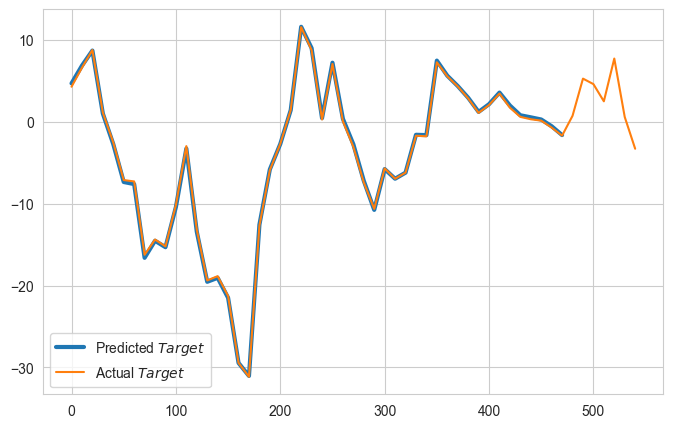

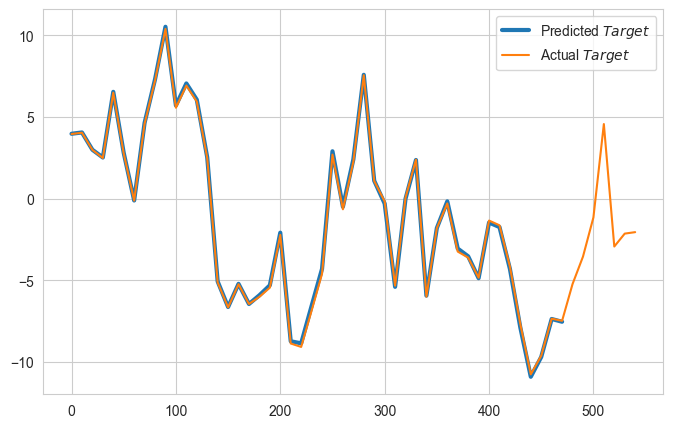

In [81]:
stock_id = 50
df_f = df_0[df_0['stock_id'] == stock_id]
target = df_f['target']
target.index = df_f['seconds_in_bucket']
plt.plot(pd.Series(data=res.T[stock_id], index=range(0, 480, 10)), label="Predicted $Target$", linewidth=3)
plt.plot(target, label="Actual $Target$")
plt.legend()

